<h2 style='color: crimson; border-bottom: 1px seagreen dotted'>MUMBAI TRAVEL TIMES {Q4 2019}</h2>

Access Dataset here ---> [Uber Movement Mumbai](https://movement.uber.com/explore/mumbai/travel-times/query?si=254&ti=&ag=hexclusters&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=72.9132679,19.1334302&sdn=Indian%20Institute%20of%20Technology%20Bombay,%20Main%20Gate%20Rd,%20IIT%20Area,%20Powai,%20Mumbai,%20Maharashtra&lng.=72.8508724&lat.=19.122537&z.=10.01&lang=en-US)

![Mumbai Trave Times](mumbai_hexagons.png)
<p style='color:orange; padding-left: 20em; border: seagreen 1px dotted'> MUMBAI ORIGIN DESTINATION TRAVELTIME HEATMAP </p>

In [1]:
# install requirements
!pip install -q -r req.txt

In [2]:
# Unzip if not already done
import os,shutil
if not 'mumbai-hexclusters-2019-4-All-HourlyAggregate.csv' in os.listdir():
    shutil.unpack_archive(filename="mumbai-hexclusters-2019-4-All-HourlyAggregate.zip",extract_dir='.')

In [3]:
# All imports


from prettyprinter import pprint 

import numpy as np
import pandas as pd
import json


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
sns.set_style('dark')

import tensorly as tl
from tensorly.decomposition import parafac

import scipy,sklearn

In [4]:
# read dataframe and metadata

df = pd.read_csv('mumbai-hexclusters-2019-4-All-HourlyAggregate.csv')
hexagons = json.load(open('mumbai_hexclusters.json',encoding="utf8"))['features']

In [5]:
# peek into dataframe
df.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,171,206,15,2949.31,1139.79,2772.51,1.40
1,255,439,10,5045.33,839.06,4978.27,1.18
2,110,18,0,2932.71,537.47,2886.25,1.19
3,38,7,5,2690.29,741.75,2591.41,1.31
4,277,219,10,4848.73,730.67,4796.48,1.16


```python

### definition ###
hod = hour of day
```


In [6]:
# peek metadata
pprint(hexagons[0])

{
    'type': 'Feature',
    'properties': {
        'MOVEMENT_ID': '1',
        'DISPLAY_NAME': '0, Beverly Park Rd, Chandan Shanti, Mira Road East'
    },
    'geometry': {
        'type': 'Polygon',
        'coordinates': [
            [
                [72.87164792379636, 19.28533060455805],
                [72.8710709563304, 19.28699016299829],
                [72.87222988623245, 19.288411970470293],
                [72.87165291120459, 19.290071498239048],
                [72.86991701541635, 19.29030919072361],
                [72.86934004196853, 19.29196866000375],
                [72.86760418931208, 19.292206301216417],
                [72.86702721744616, 19.293865712003942],
                [72.86529140792581, 19.294103301944087],
                [72.86413260267913, 19.292681516129214],
                [72.86470956539794, 19.291022133151962],
                [72.86355078499479, 19.289600351689437],
                [72.86412774015048, 19.287940938034637],
                [72.862

In [7]:
#test all unique
gdf = df.groupby(['sourceid','dstid', 'hod']).count()

if np.all(gdf==1): print('All good, no repeats')
else: print('Some src-dst-hod are repeated!!!')

All good, no repeats


In [8]:
origins = sorted(df.sourceid.unique())
destinations = sorted(df.dstid.unique())
hods = sorted(df.hod.unique())

origin_max = max(origins)
dest_max = max(destinations)
hod_max = max(hods)

list(map(min,[origins,destinations,hods]))

[1, 1, 0]

In [9]:
# Make numpy tensor
nptensor = np.zeros(     (   dest_max, origin_max, hod_max+1  )      ) 
        
def transfer(x):
    nptensor[x.dstid-1 ,x.sourceid-1, x.hod] = x.mean_travel_time
    return 0

df.pipe(transfer)

0

In [10]:
nptensor[300,3,10]

1718.02

In [11]:
# verify if nptensor has right data
df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]

<ipython-input-11-485e33becc57>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]
<ipython-input-11-485e33becc57>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
1261503,4,301,10,1718.02,619.9,1633.91,1.35


In [12]:
# create tensorly data
#nptensor -= nptensor.mean()
tensor = tl.tensor(nptensor)

In [13]:
# decompose
factors = parafac(tensor, rank=1)
weights, components = factors
print(factors)
print(weights)


(weights, factors) : rank-1 CPTensor of shape (695, 695, 24) 
[1.]


In [14]:
dst,src,hr = components
dst,src,hr = map(np.array, [dst,src,hr])



In [15]:
hr.shape

(24, 1)

<AxesSubplot:>

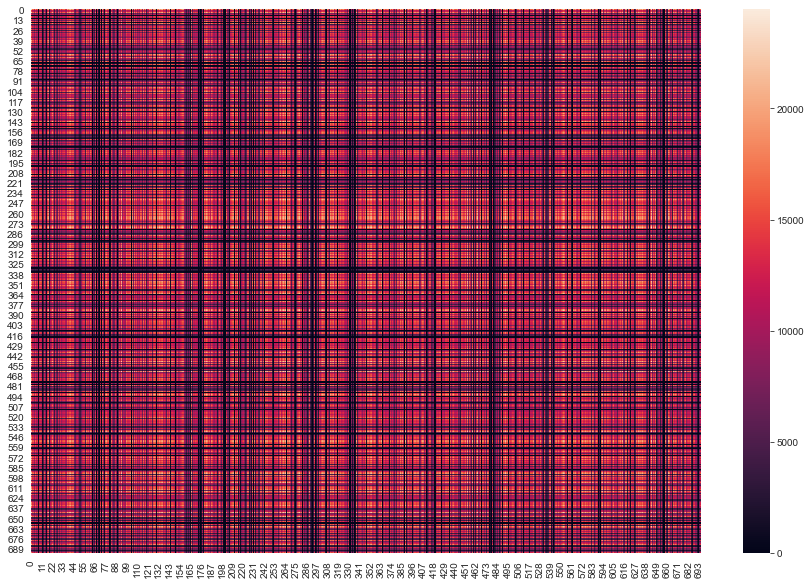

In [16]:
sns.heatmap(dst @ src.T)

<AxesSubplot:>

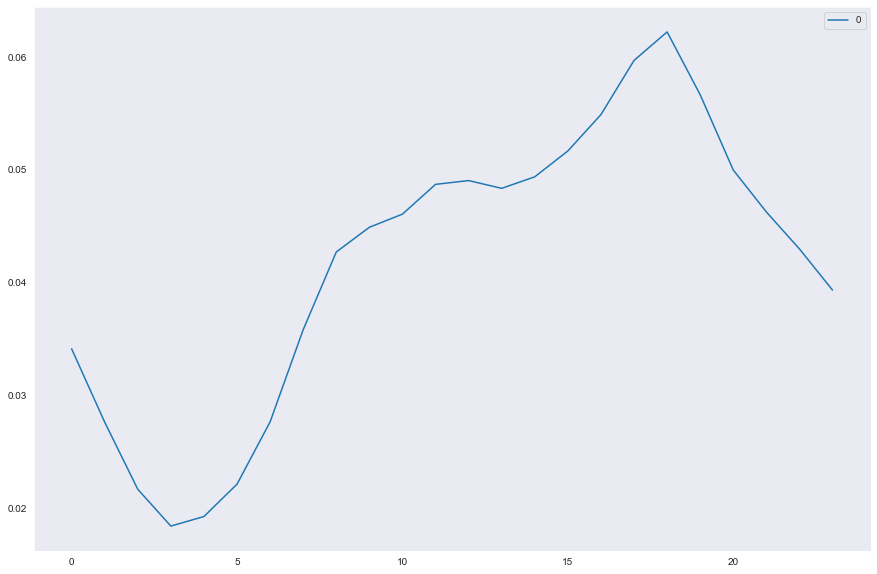

In [17]:
sns.lineplot(data=hr/hr.sum())

In [18]:
'''https://www.tomtom.com/en_gb/traffic-index/mumbai-traffic/'''
tomtom2019 = '''31%
16%
6%
0%
0%
0%
2%
9%
14%
19%
27%
39%
47%
46%
43%
47%
52%
57%
64%
67%
59%
48%
43%
33%
18%
3%
0%
0%
0%
0%
3%
26%
61%
80%
78%
70%
66%
59%
55%
58%
63%
76%
96%
104%
89%
66%
47%
30%
17%
6%
2%
0%
0%
0%
5%
27%
60%
80%
80%
74%
71%
65%
62%
65%
70%
82%
102%
109%
93%
70%
51%
34%
19%
6%
0%
0%
0%
0%
6%
29%
62%
83%
84%
79%
75%
69%
66%
68%
72%
83%
103%
109%
94%
71%
52%
35%
19%
6%
0%
0%
0%
0%
5%
27%
59%
78%
78%
73%
71%
66%
62%
65%
70%
82%
103%
111%
96%
72%
52%
35%
20%
6%
1%
0%
0%
1%
7%
29%
60%
80%
83%
80%
76%
67%
62%
68%
76%
90%
111%
119%
104%
81%
61%
44%
28%
11%
3%
0%
0%
2%
7%
18%
27%
38%
49%
63%
71%
71%
70%
74%
79%
83%
89%
91%
79%
63%
54%
44%'''

In [19]:
tomtomMatrix2019 = np.array(tomtom2019.replace('%','').split('\n'), dtype=np.int64).reshape(7,24)

<AxesSubplot:>

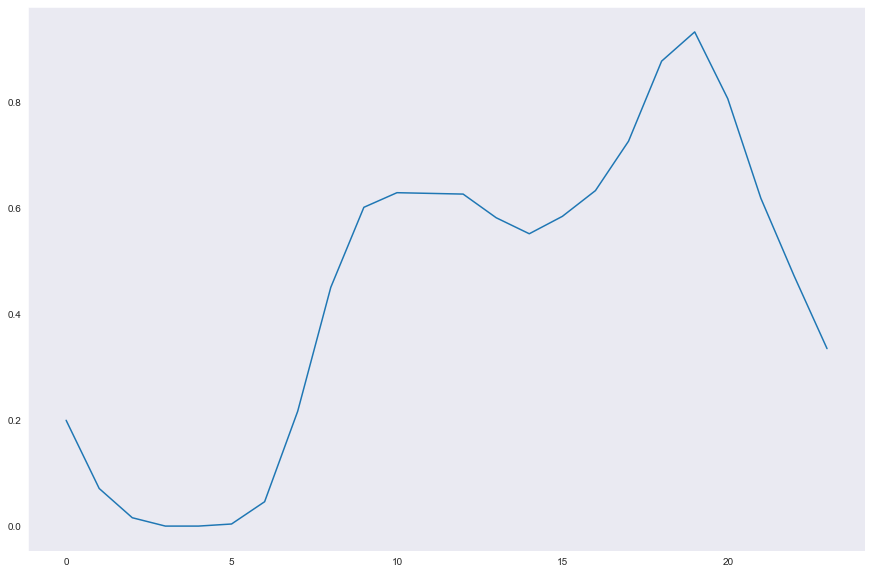

In [20]:
sns.lineplot(data=tomtomMatrix2019.sum(axis=0)/np.linalg.norm(tomtomMatrix2019))

In [21]:
tomtomnorm=tomtomMatrix2019.sum(axis=0).reshape(-1,1)/np.linalg.norm(tomtomMatrix2019.sum(axis=0))
hrnorm = hr/np.linalg.norm(hr)

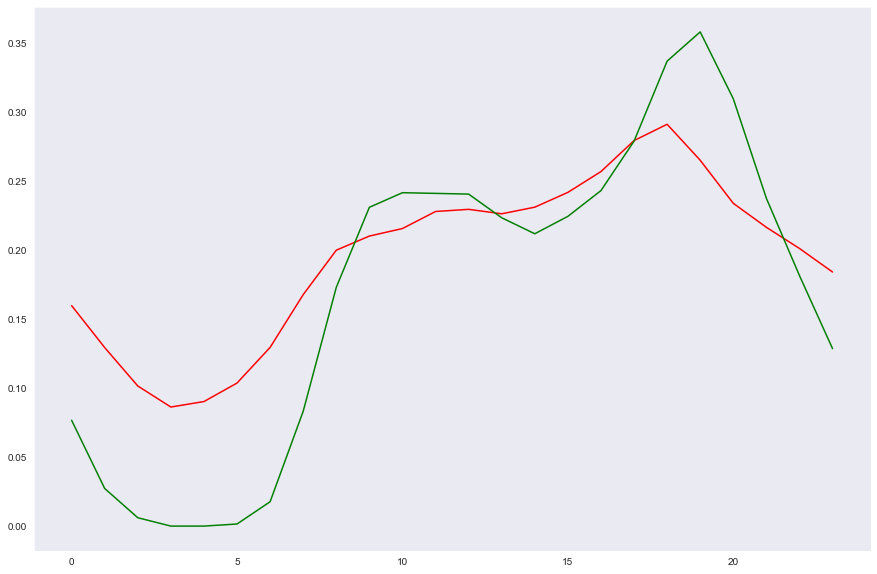

In [22]:
plt.plot(hrnorm,c='r')
plt.plot(tomtomnorm,c='g')

In [23]:
### To do 

# Center to zero the Tensor before decomp i.e nptensor = (nptensor - nptensor.mean())

In [24]:
# Tensor to Matrix

gd,gs,tslots = nptensor.shape

npmatrix = np.zeros((gd*gs, tslots))

for t in range(tslots):
    a = nptensor[:,:,t]
    npmatrix[:,t] = a.flatten()

In [25]:
# numpy svd fails due to insufficient memory, need to use scipy
#np.linalg.svd(npmatrix)

In [26]:
# try SVD using sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
# https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
import sklearn.decomposition


svd = sklearn.decomposition.TruncatedSVD(n_components=2, n_iter=20, random_state=42)
svd.fit(npmatrix)


TruncatedSVD(n_iter=20, random_state=42)

[0.80076823 0.03914935]
0.8399175718190734


<AxesSubplot:>

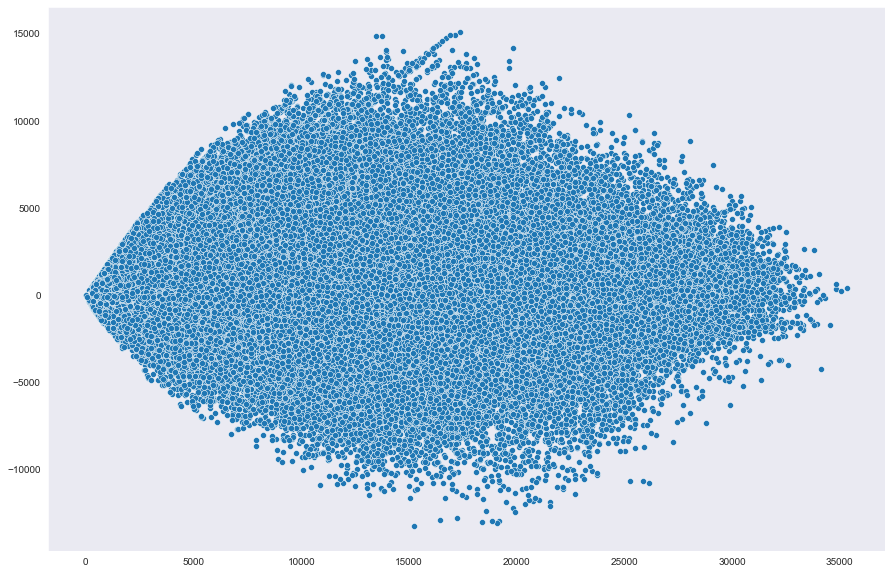

In [27]:
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
decomp = svd.transform(npmatrix)
sns.scatterplot(x=decomp[:,0],y=decomp[:,1])

In [28]:
# https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
from scipy.sparse.linalg import svds
u, s, v = svds(npmatrix, k=1)

In [29]:
print(v.shape)
print(u.shape)
print(s.shape)
print(npmatrix.shape)

(1, 24)
(483025, 1)
(1,)
(483025, 24)


In [30]:
uproj = (npmatrix.T @ u)

In [31]:
uprojnorm = uproj/np.linalg.norm(uproj)

<AxesSubplot:>

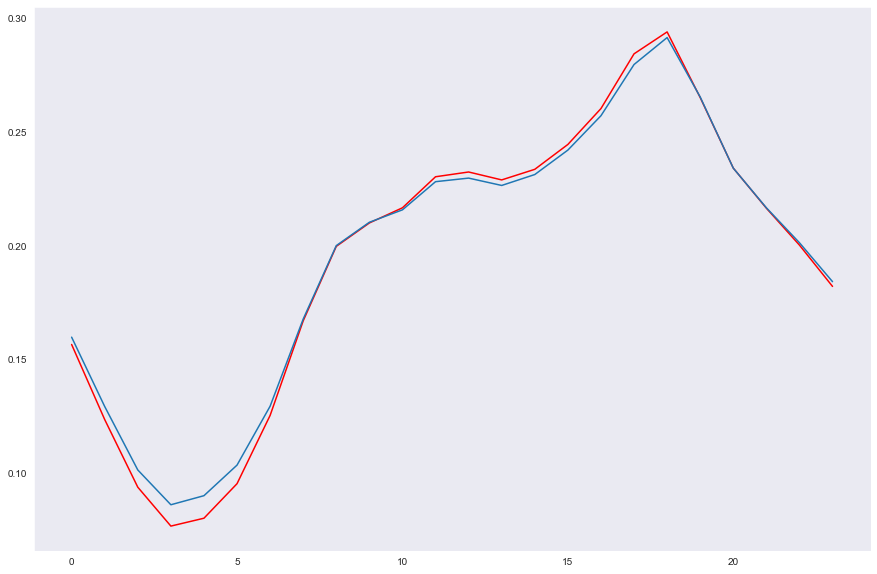

In [32]:
sns.lineplot(data=pd.Series(uprojnorm.flatten()), color='red')
sns.lineplot(data=pd.Series(hrnorm.flatten()))

In [33]:
print(v.shape)
print(u.shape)
print(s.shape)
print(npmatrix.shape)

(1, 24)
(483025, 1)
(1,)
(483025, 24)


In [34]:
vproj = npmatrix @ v.T

In [46]:
vprojnorm = vproj / np.linalg.norm(vproj)
vprojnorm = vprojnorm.flatten()

<AxesSubplot:>

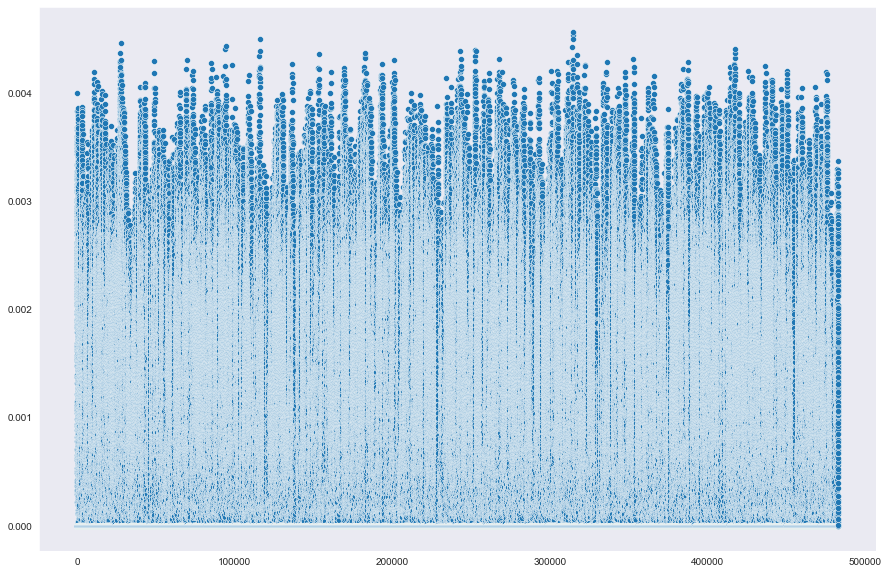

In [48]:
sns.scatterplot(x=range(len(vprojnorm)),y=vprojnorm)

In [49]:
print(dst.shape)
print(src.shape)

(695, 1)
(695, 1)


In [74]:
dstsrc_comp = dst @ src.T
#dstsrc_comp = src @ dst.T

dstsrc = dstsrc_comp.flatten()

dstsrcnorm = dstsrc / np.linalg.norm(dstsrc)

In [75]:
dstsrcnorm.shape == vprojnorm.shape and list(map(np.linalg.norm,[vprojnorm,dstsrcnorm]))==[1.0,1.0]

True

In [76]:
# Find correlation and angle
print('Corr->',dstsrcnorm @ vprojnorm)
print('Angle->', np.rad2deg(np.arccos(dstsrcnorm @ vprojnorm)))


Corr-> 0.8659622775108451
Angle-> 30.007232947376888


In [80]:
sum_ = npmatrix.sum(axis=0)

In [81]:
sum_norm = sum_ / np.linalg.norm(sum_)

<AxesSubplot:>

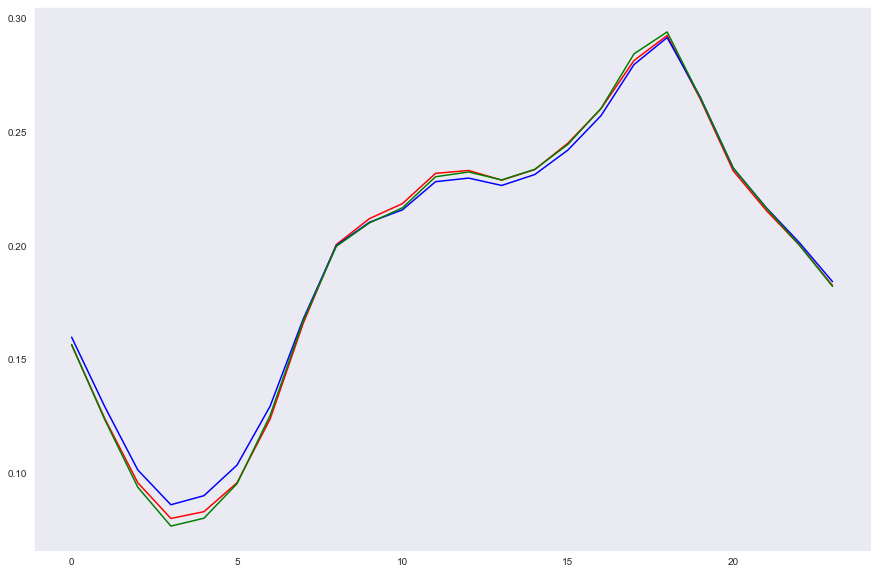

In [86]:
sns.lineplot(data=pd.Series(sum_norm), color='red')
sns.lineplot(data=pd.Series(hrnorm.flatten()), color='blue')
sns.lineplot(data=pd.Series(uprojnorm.flatten()), color='green')

In [88]:
sum_src_dst = nptensor.sum(axis=2)
sum_src_dst.shape

(695, 695)

In [90]:
sum_src_dst_vec = sum_src_dst.flatten()
sum_src_dst_vec_norm = sum_src_dst_vec / np.linalg.norm(sum_src_dst_vec)

In [93]:
print('Corr with Matrix decomp.')
sum_src_dst_vec_norm @ vprojnorm

Corr with Matrix decomp.


0.9988920469877127

In [94]:
print('Corr with Tensor decomp.')
sum_src_dst_vec_norm @ dstsrcnorm

Corr with Tensor decomp.


0.8707054362101746

In [95]:
sum_src = nptensor.sum(axis=2).sum(axis=0)
sum_src.shape

(695,)

In [103]:
sum_src_norm = sum_src / np.linalg.norm(sum_src)

In [105]:
src_norm = src / np.linalg.norm(src)
sum_src_norm @ src_norm

array([0.99760746])

In [114]:
k2 = npmatrix.sum(axis=1)
k2norm = k2/np.linalg.norm(k2)

k2norm @ vprojnorm

0.9988920469877127

<AxesSubplot:>

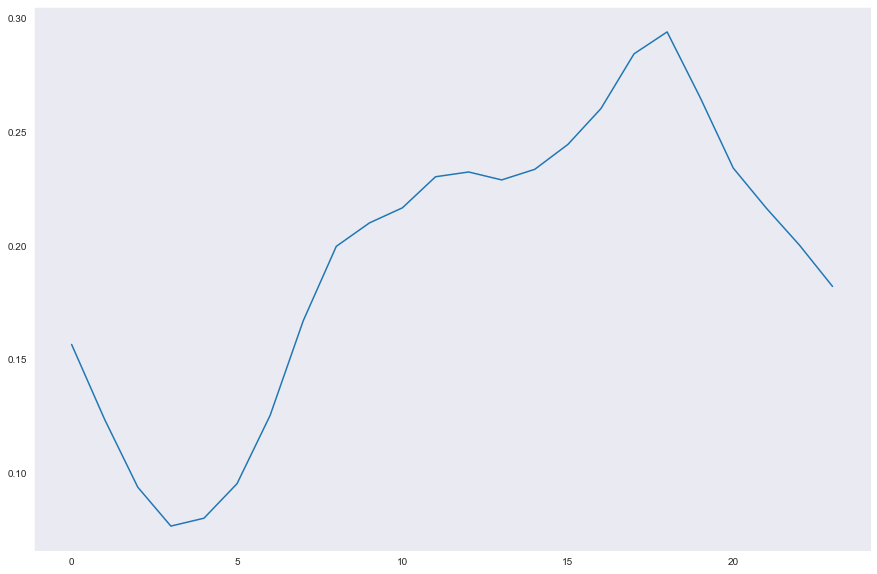

In [123]:
sns.lineplot(data=v.flatten())


In [128]:
A = np.random.random((2,2))

In [127]:
u,s,v = np.linalg.svd(A)

In [135]:
C = A.T @ A
gr = np.random.multivariate_normal([0,0], C,100)

In [137]:
u,s,v = np.linalg.svd(gr)

c:\users\bzsnk3\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

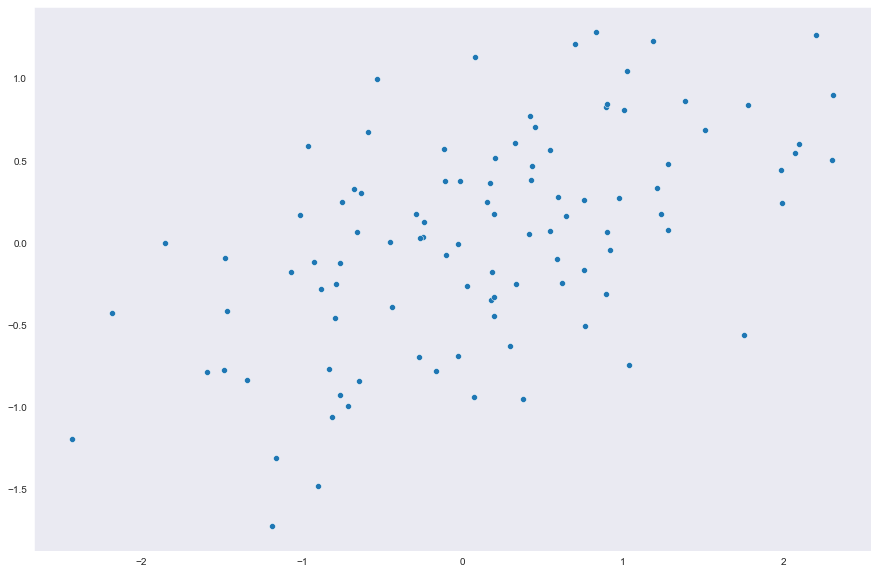

In [139]:
sns.scatterplot(gr[:,0],gr[:,1])

In [146]:
e1=u[:,0]

In [152]:
sum1 = gr.sum(axis=1)
sum1norm = sum1 / np.linalg.norm(sum1)

<AxesSubplot:>

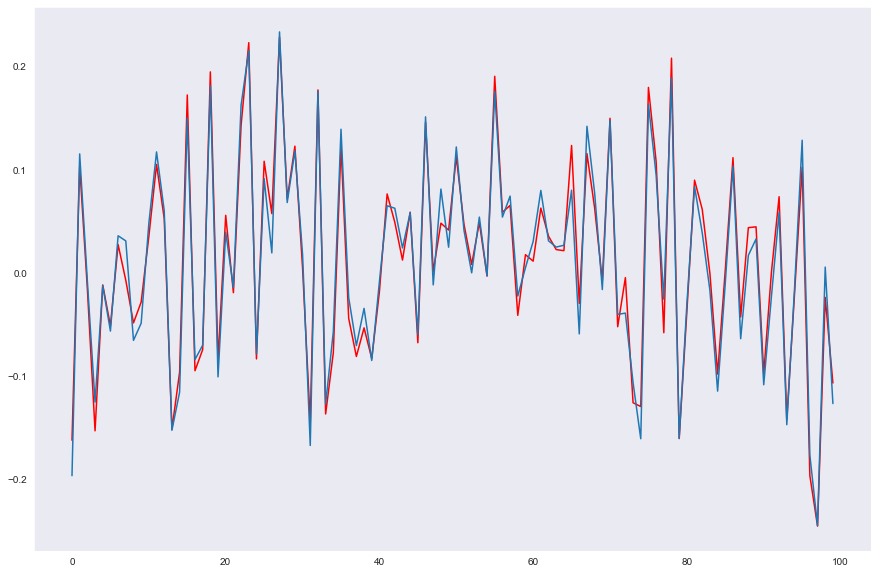

In [154]:
sns.lineplot(data=pd.Series(e1),color='red')
sns.lineplot(data=sum1norm)